In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck P. Vidal (UKRI-STFC)

In [2]:
path = "/DATA/2023/DTHE/ZrO2-Cu-1mm-10umvx"

In [3]:
import os


from DTHEDataReader import *
from cil.io import TIFFWriter
from cil.processors import TransmissionAbsorptionConverter, Slicer
from cil.recon import FDK
from cil.plugins.astra import FBP

from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer, link_islicer

from cil.plugins.astra.operators import ProjectionOperator
from cil.optimisation.algorithms import CGLS, SIRT

## Load the data

In [4]:
filename = os.path.join(path, "unireconstruction.xml")

reader = DTHEDataReader(file_name=filename)
data = reader.read()

## Inspect the geometry

Checkout what the data looks like

In [5]:
print(data)

Number of dimensions: 3
Shape: (544, 716, 716)
Axis labels: ('angle', 'vertical', 'horizontal')



Checkout what the acquisition geometry looks like

In [6]:
print(data.geometry)

3D Cone-beam tomography
System configuration:
	Source position: [  0.    , -32.4179,   0.    ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.    , 453.8781,   0.    ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [716 716]
	Pixel size: [0.15 0.15]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 544
	Angles 0-20 in degrees:
[ -0.       ,  -0.6629834,  -1.3259668,  -1.9889503,  -2.6519337,
  -3.314917 ,  -3.9779005,  -4.640884 ,  -5.3038673,  -5.9668508,
  -6.629834 ,  -7.2928176,  -7.955801 ,  -8.618785 ,  -9.281768 ,
  -9.944752 , -10.607735 , -11.270719 , -11.9337015, -12.596685 ]
Distances in units: units distance


CIL can even plot what the geometry looks like

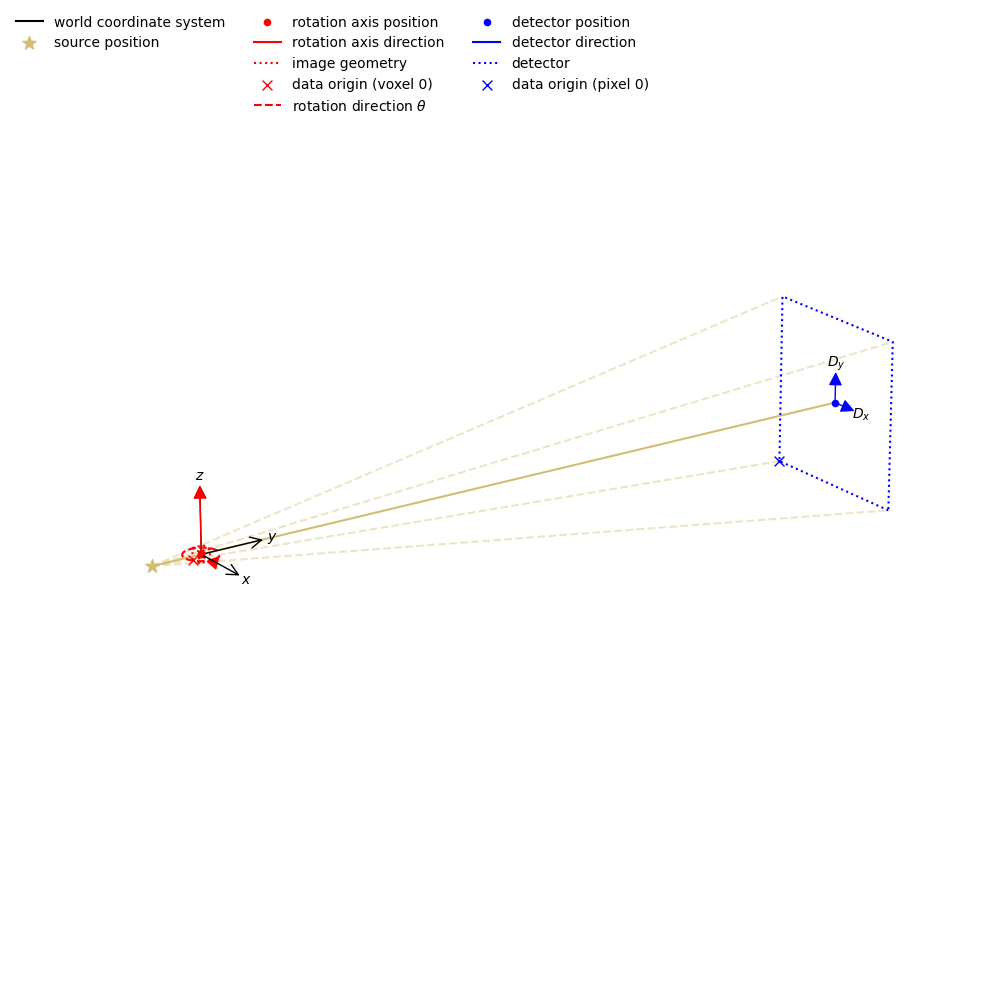

Saved image as /home/fpvidal/PROGRAMMING/GitHub/CIL-DTHE-Reader/geometry.png


<Figure size 640x480 with 0 Axes>

In [7]:
show_geometry(data.geometry).save("geometry.png")

## Inspect the projections

In [8]:
islicer(data, direction='angle')

Apply the minus log

In [9]:
data = TransmissionAbsorptionConverter()(data)

Inspect the projections

In [10]:
islicer(data, direction='angle')

## FDK using Tigre

In [12]:
data.reorder(order='tigre')
ig = data.geometry.get_ImageGeometry()
fdk =  FDK(data, ig)
recons_FDK_tigre = fdk.run()

FDK recon

Input Data:
	angle: 544
	vertical: 716
	horizontal: 716

Reconstruction Volume:
	vertical: 716
	horizontal_y: 716
	horizontal_x: 716

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



In [13]:
visualisation_window = (0.0, 0.3)
islicer(recons_FDK_tigre, direction='vertical', minmax=visualisation_window)

In [14]:
islicer(recons_FDK_tigre, direction='horizontal_x', minmax=visualisation_window)

We can save the reconstructed volume to disk for example as a stack of TIFFs:

In [15]:
save_base_path = os.getcwd()
save_path = os.path.join(path, "recons_FDK_tigre")
print("Print the CT data will be saved in:", save_path)

if not os.path.isdir(save_path):
    os.makedirs(save_path)

TIFFWriter(data=recons_FDK_tigre, file_name=os.path.join(save_path, "out")).write()

Print the CT data will be saved in: /DATA/2023/DTHE/ZrO2-Cu-1mm-10umvx/recons_FDK_tigre


## FDK using ASTRA Toolbox

In [16]:
data.reorder('astra')
ig = data.geometry.get_ImageGeometry()
fbp =  FBP(ig, data.geometry)
recons_FDK_astra = fbp(data)

In [17]:
save_base_path = os.getcwd()
save_path = os.path.join(path, "recons_FDK_astra")
print("Print the CT data will be saved in:", save_path)

if not os.path.isdir(save_path):
    os.makedirs(save_path)

TIFFWriter(data=recons_FDK_astra, file_name=os.path.join(save_path, "out")).write()

Print the CT data will be saved in: /DATA/2023/DTHE/ZrO2-Cu-1mm-10umvx/recons_FDK_astra


## Compare the two reconstructions using synchronised views

In [18]:
sl1 = islicer(recons_FDK_tigre, minmax=visualisation_window)
sl2 = islicer(recons_FDK_astra, minmax=visualisation_window)
link_islicer(sl1, sl2)

## Iterative reconstruction

Create the projector

In [20]:
ag = data.geometry.copy()
A = ProjectionOperator(ig, ag, device="gpu")

Create the initial guess

In [21]:
x0 = ig.allocate(0.0)


## SIRT reconstruction

In [22]:
mysirt_lower0 = SIRT(initial=x0,
                     operator=A,
                     data=data,
                     max_iteration=1000,
                     lower=0.0,
                     update_objective_interval=50)

In [23]:
mysirt_lower0.run(10, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          7.44052e+06
-------------------------------------------------------
       10       1000         4.942                     
Stop criterion has been reached.



In [24]:
islicer(mysirt_lower0.solution, direction='vertical', minmax=visualisation_window)

In [25]:
mysirt_lower0.run(100, verbose=1)
islicer(mysirt_lower0.solution, direction='vertical', minmax=visualisation_window)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       10       1000         4.942                     
       50       1000         4.958          3.06091e+02
      100       1000         4.953          2.33910e+02
-------------------------------------------------------
      110       1000         4.946                     
Stop criterion has been reached.



## CGLS reconstruction

In [26]:
cgls = CGLS(initial=x0, 
            operator=A, 
            data=data,
            max_iteration = 10,
            lower=0.0,
            update_objective_interval = 1 )

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         10         0.000          7.44052e+06
        1         10         4.834          1.45159e+06
        2         10         4.846          1.95047e+05
        3         10         4.850          1.01180e+05
        4         10         4.854          6.31940e+04
        5         10         4.852          3.34134e+04
        6         10         4.851          2.48341e+04
        7         10         4.851          1.79141e+04
        8         10         4.853          1.49301e+04
        9         10         4.853          1.33586e+04
       10         10         4.853          1.12453e+04
-------------------------------------------------------
       10         10         4.853          1.12453e+04
Stop criterion has been reached.



In [ ]:
cgls.run(5, verbose=True)
islicer(cgls.solution, direction='vertical', minmax=visualisation_window)

In [31]:
cgls.run(100, verbose=1)
islicer(cgls.solution, direction='vertical', minmax=visualisation_window)

Stop criterion has been reached.
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       11         10         4.865          1.05731e+04
-------------------------------------------------------
       11         10         4.865          1.05731e+04
Stop criterion has been reached.

